In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/lustre/groups/ml01/datasets/annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cpu


In [6]:
# path to dir containing pwm txt files
base_path = Path('/Users/egeerdogan/Downloads/Homo_sapiens/pwms_all_motifs')

Load all pwms into separate dataframes.

In [ ]:
# collect paths to all pwms
motif_paths = []
for p in base_path.rglob('*'):
    motif_paths.append(p)

pwms = [pd.read_csv(p, sep='\t').drop(columns=['Pos'], axis=1) for p in motif_paths]

In [ ]:
pwms[0]

**TODO**: assign a `Multibind` instance to `multibind_model`.

In [ ]:
# TODO 
multibind_model = None 

filter_dists = [] # list of distance lists for each multibind filter
for mb_filter in multibind_model.binding_modes.conv_mono[1:]: # skip first None filter
    dists = [] # distance list of one multibind filter for each pwm
    for i, pwm in enumerate(tqdm(pwms, leave=False)):
        if pwm.shape[0] > 5: 
            a = mb_filter.weight.detach().numpy()
            a = a.reshape((4, a.shape[-1]))
            b = pwm.values.T 
            d = mb.tl.min_distance(a, b)
            dists.append(d)
    filter_dists.append(dists)

In [ ]:
print('Layer\tMin dist\t\tIndex')
for i, dists in enumerate(filter_dists):
    min_dist = min(dists)
    print(f'{i}\t{min_dist}\t{dists.index(min_dist)}')

## cisbp motifs

In [22]:
CISBP_PATH = Path('/home/icb/ege.erdogan/pwms')

In [23]:
def load_cisbp_motif(id):
    return pd.read_csv(f'{CISBP_PATH}/{id}.txt', sep='\t').drop(columns=['Pos'], axis=1)

In [24]:
ctcf_ids = ['M05846_2.00', 'M02878_2.00']

In [25]:
ctcf_pwms = [load_cisbp_motif(id) for id in ctcf_ids]
# for id in ctcf_ids:
#     pwm = load_cisbp_motif(id)
#     conv = torch.nn.Conv2d(4, 1, (4, pwm.shape[0]), bias=False)
#     conv.weight.data = torch.tensor(pwm.values.T).unsqueeze(0).unsqueeze(0).float()
#     convs.append(conv)

print('loaded', len(ctcf_pwms), 'pwms')

loaded 2 pwms


In [28]:
def unfreeze(model, feat_lab=None, position=None):
    # block mononucleotide but free dinucleotide and activities to calibrate themselves during training
    verbose = 1
    for ki in range(2 + 1):
        mask_pos = (ki == position if position is not None else True)
        mask_mono = (feat_lab == 'mono') and mask_pos
        mask_dinuc = (feat_lab == 'dinuc') and mask_pos
        if verbose != 0:
            print("setting grad status of kernel (mono, dinuc) at %i to (%i, %i)" % (ki, mask_mono, mask_dinuc))
        model.binding_modes.update_grad_mono(ki, mask_mono)
        model.binding_modes.update_grad_di(ki, mask_dinuc)

### Load CTCF dataset

In [29]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)

df.index = df['seq']
del df['seq']
df = df[~df.index.duplicated(keep='first')]

n_sample = 10000
data = df.sample(min(df.shape[0], n_sample))

In [44]:
n_rounds = 2
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0,1])
trainloader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=256,
                                          shuffle=False)

### Init model

(10, 10)


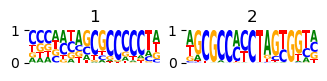

In [54]:
criterion = mb.tl.PoissonLoss()

n_rounds = trainloader.dataset.n_rounds
n_batches = trainloader.dataset.n_batches
enr_series = trainloader.dataset.enr_series

model = mb.models.Multibind(
    datatype='selex',
    kernels = [0] + [m.shape[0] for m in ctcf_pwms],
    n_rounds = n_rounds,
    init_random=False,
    n_batches = n_batches,
    enr_series=enr_series,
    dinuc_model='local',
).to(device)

for i, w in enumerate(ctcf_pwms):
    model.binding_modes.conv_mono[i + 1].weight.data = torch.tensor(w.values.T).unsqueeze(0).unsqueeze(0).float()

mb.pl.conv_mono(model.binding_modes, n_rows=10, n_cols=10, xticks=False, yticks=False)

In [55]:
model

Multibind(
  (padding): ConstantPad2d(padding=(16, 16, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 1x2]
        (1): Parameter containing: [torch.FloatTensor of size 1x2]
        (2): Parameter containing: [torch.FloatTensor of size 1x2]
    )
  )
  (selex_module): SelexModule()
)

### Freeze weights and train

In [35]:
unfreeze(model, None)

model.binding_modes.update_grad_mono(0, True)
model.binding_modes.update_grad_di(0, True)

setting grad status of kernel (mono, dinuc) at 0 to (0, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)


In [56]:
opt = torch.optim.Adam(model.parameters(), lr=0.025, weight_decay=0.001)
early_stopping = 25
log_each = 10
dirichlet_regularization = 0
exp_max = 40
verbose = 1
num_epochs = 100

mb.tl.optimize_simple(
    model, 
    trainloader,
    device,
    opt,
    criterion,
    num_epochs=num_epochs,
    early_stopping=early_stopping,
    log_each=log_each,
    dirichlet_regularization=dirichlet_regularization,
    exp_max=exp_max,
    verbose=verbose,
)

optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 100 
early_stopping: 25
lr= 0.025, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.843461,  best epoch: 7,  secs per epoch: 16.372 s,  secs epoch*1k trials: 1.637s
Epoch: 21, Loss: 0.844036,  best epoch: 7,  secs per epoch: 15.614 s,  secs epoch*1k trials: 1.561s
Epoch: 31, Loss: 0.844350,  best epoch: 7,  secs per epoch: 14.998 s,  secs epoch*1k trials: 1.500s
Epoch: 33, Loss: 0.8444,  best epoch: 7,  secs per epoch: 14.958s,  secs epoch*1k trials: 1.496s
early stop!
Final loss: 0.8443956271
Total time (model/function): (478.668s / 478.668s)
Time per epoch (model/function): (14.958s/ 14.958s)
Time per epoch per 1k trials: 1.496s
Current time: 2023-01-24 13:15:00.368986


In [39]:
mb.tl.scores(model, trainloader, by='batch')

{0: {'r2_counts': 0.06630103404652787,
  'r2_foldchange': 0.026155400070014934,
  'r2_enr': -0.07330879182127825,
  'r2_fc': 0.031113606956795777,
  'pearson_foldchange': 0.17639049565324028}}

True
3
(12, 12)
(12, 12)


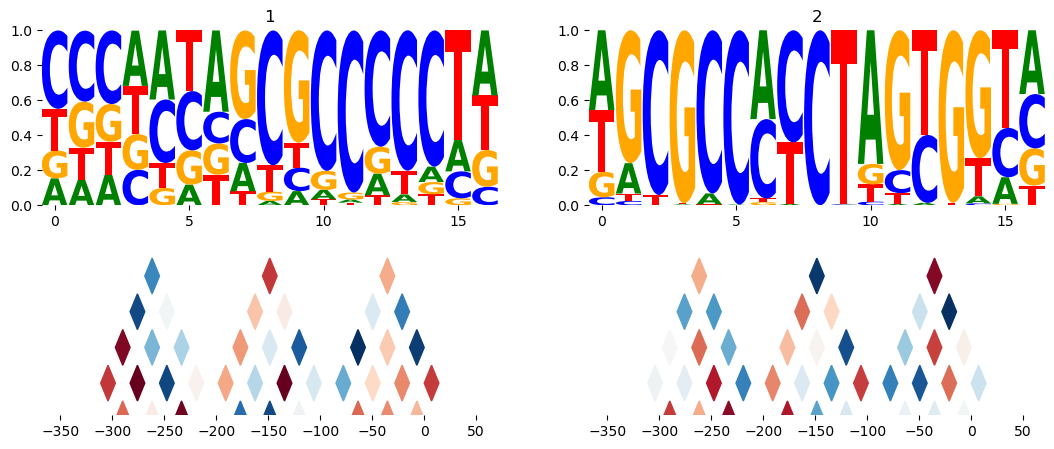

In [40]:
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2)